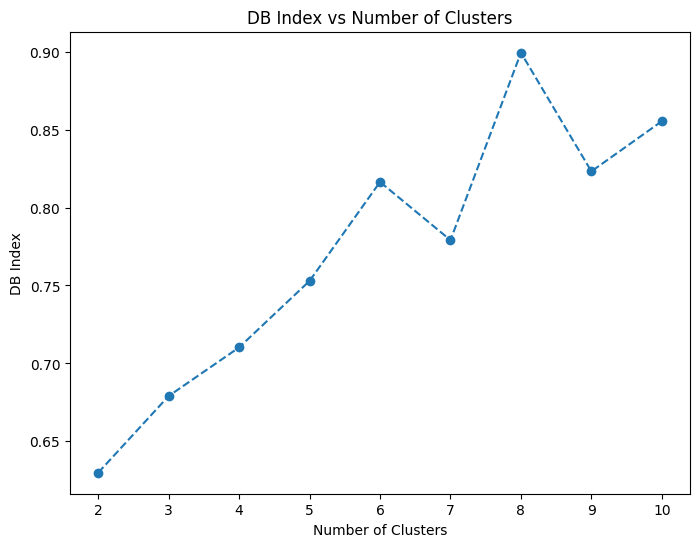

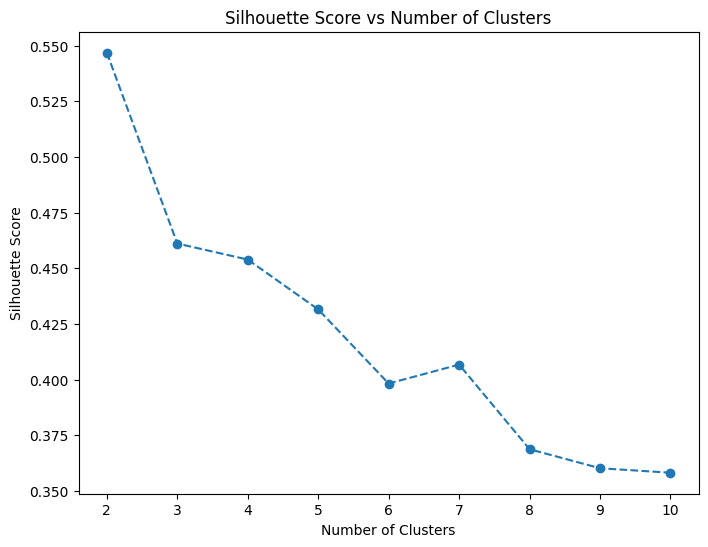

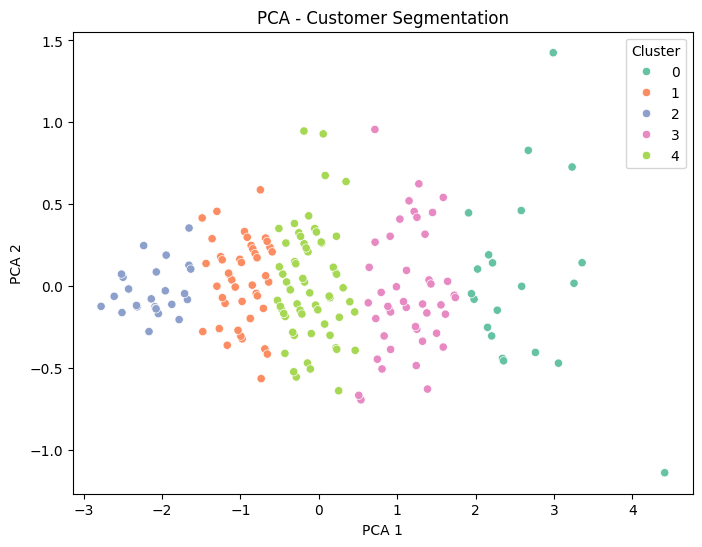

Optimal Number of Clusters: 5
Silhouette Score: 0.4315131216122971
DB Index: 0.7529350579420507
  Cluster   TotalValue              Quantity       
                  mean        sum       mean    sum
0       0  6780.821905  142397.26  24.190476  508.0
1       1  2158.694255  101458.63   8.553191  402.0
2       2   745.540000   18638.50   3.320000   83.0
3       3  4986.165682  219391.29  17.500000  770.0
4       4  3303.331429  208109.88  12.285714  774.0


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge customers with their transaction details
customer_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
}).reset_index()

# Merge with customer profile information
customer_data = pd.merge(customers, customer_transactions, on='CustomerID', how='left')

# Handle missing values by filling with zeros (if any)
customer_data.fillna(0, inplace=True)

# Standardize the data for clustering (optional but recommended)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['TotalValue', 'Quantity']])

# Find the optimal number of clusters using DB Index and Silhouette Score
db_index = []
sil_scores = []
inertia = []

for k in range(2, 11):  # Testing for clusters between 2 and 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)

    # Calculate DB Index
    dbi = davies_bouldin_score(scaled_data, kmeans.labels_)
    db_index.append(dbi)

    # Calculate Silhouette Score
    sil_score = silhouette_score(scaled_data, kmeans.labels_)
    sil_scores.append(sil_score)

    # Record Inertia (sum of squared distances)
    inertia.append(kmeans.inertia_)

# Plot DB Index vs. Number of Clusters
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), db_index, marker='o', linestyle='--')
plt.title('DB Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

# Plot Silhouette Score vs. Number of Clusters
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), sil_scores, marker='o', linestyle='--')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Using k = 5 based on DB Index and Silhouette Score analysis
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

# PCA for visualizing the clusters in 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# Plot PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=customer_data['Cluster'], palette='Set2')
plt.title('PCA - Customer Segmentation')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

# Save segmented customers to a CSV file
customer_data[['CustomerID', 'Cluster']].to_csv('Segmented_Customers.csv', index=False)

# Final Clustering Metrics
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Silhouette Score: {silhouette_score(scaled_data, customer_data['Cluster'])}")
print(f"DB Index: {davies_bouldin_score(scaled_data, customer_data['Cluster'])}")

# Optional: Further cluster analysis (summary statistics, customer segmentation insights)
cluster_summary = customer_data.groupby('Cluster').agg({
    'TotalValue': ['mean', 'sum'],
    'Quantity': ['mean', 'sum']
}).reset_index()

print(cluster_summary)
